# Проект: вариант 2

## A/B–тестирование

### Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### Входные данные

В качестве входных данных Вы имеете 4 csv-файла:
- `groups.csv` - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе **(А – контроль, B – целевая группа)** 
- `groups_add.csv` - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- `active_studs.csv` - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- `checks.csv` - файл с информацией об оплатах пользователей в дни проведения эксперимента.

### Вопросы

Предлагаем Вам ответить на следующие вопросы:

1. На какие метрики Вы смотрите в ходе анализа и почему?
2. Имеются ли различия в показателях и с чем они могут быть связаны?
3. Являются ли эти различия статистически значимыми?
4. Стоит ли запускать новую механику на всех пользователей?
5. Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

### Требования к ответу

- При выполнении тестового задания необходимо использовать язык программирования Python. 
- В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
- Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

In [1]:
import pandas as pd
# import requests
# from urllib.parse import urlencode

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import numpy as np
from tqdm.auto import tqdm

import pandahouse as ph

In [2]:
# ДАННЫЙ КОД СТАЛ ВЫДАВАТЬ ОШИБКУ (РАНЬШЕ РАБОТАЛ), ПРОБЛЕМА НА СТОРОНЕ API ЯНДЕКС ДИСКА


# # считывание данных с помощью api
# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
# public_key = ['https://disk.yandex.ru/d/UhyYx41rTt3clQ',
#               'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ',
#               'https://disk.yandex.ru/d/pH1q-VqcxXjsVA']

# groups = pd.DataFrame()
# active_studs = pd.DataFrame()
# checks = pd.DataFrame()
# df = ['groups', 'active_studs', 'checks']

# for i, j in zip(public_key, df):
#     final_url = base_url + urlencode(dict(public_key=i))
#     response = requests.get(final_url)
#     download_url = response.json()['href']
#     locals()[j] = pd.read_csv(download_url, sep=';')

# # groups_add считываем отдельно, без разделителя
# download_url_add = requests.get(base_url + 
#                                 urlencode(dict(public_key='https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'))).json()['href']
# groups_add = pd.read_csv(download_url_add)

In [3]:
groups = pd.read_csv('groups.csv', sep=';')
groups_add = pd.read_csv('group_add.csv')
active_studs = pd.read_csv('active_studs.csv', sep=';')
checks = pd.read_csv('checks.csv', sep=';')

Проверим таблицы на пропуски, NaN и уникальные значения:

In [4]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
groups.id.nunique()

74484

In [6]:
groups.describe(include='object')

,grp
count,74484
unique,2
top,B
freq,59813


In [7]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [8]:
groups_add.id.nunique()

92

In [9]:
active_studs.student_id.nunique()

8341

In [10]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [11]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [12]:
# 541 чек - по одному чеку на каждого пользователя
checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

Все значения id уникальны. Пропуски, NaN, нулевые значения отсутствуют.

Объединим основной файл с дополнительным и добавим колонку с указанием, заходил ли пользователь на платформу в дни проведения эксперимента (если заходил - в колонке будет 1, не заходил - 0).

In [13]:
groups_full = pd.concat([groups, groups_add]).rename(columns={'id': 'student_id'}).reset_index(drop=True)

In [14]:
active_studs['activity'] = 1

In [15]:
groups_full = groups_full.merge(active_studs, on='student_id', how='left').fillna(0)

In [16]:
groups_full.activity.value_counts()

0.0    66235
1.0     8341
Name: activity, dtype: int64

Добавим к нашему датасету чеки, собрав таким образом все данные в одну таблицу.

In [17]:
df = groups_full.merge(checks, how='left').fillna(0).reset_index(drop=True)

Общий датасет выглядит так:

In [18]:
df.head()

,student_id,grp,activity,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0


Посмотрим на количество пользователей в группах:

In [19]:
df.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

In [20]:
# в процентах
df.grp.value_counts(normalize=True).mul(100).round(1)

B    80.3
A    19.7
Name: grp, dtype: float64

In [21]:
df_to_del = df.query('activity == 0 and rev > 0')
df_to_del.nunique()

student_id    149
grp             2
activity        1
rev            13
dtype: int64

149 пользователей не заходили на платформу, но произвели оплату в дни проведения эксперимента. Можно предположить, что у них стоит услуга "автоплатеж", и оплата была проведена автоматически, без посещения платформы. Данных пользователей не будем учитывать при проведении А/B-тестирования, так как, скорее всего, механика их оплаты на сайте не менялась и они не принимали участия в эксперименте.

Уберем из общего датасета этих пользователей.

In [22]:
# сохраним для проверки размер исходного df
df_old_len = df.shape[0]

# убираем
df = pd.concat([df, df_to_del]).drop_duplicates(keep=False)

# проверка что убрали ровно 149
df_old_len - df.shape[0]

149

In [23]:
df['pay_flag'] = (df.rev > 0) * 1
df.groupby('grp', as_index=False).agg({'student_id': 'count', 'activity': 'sum', 'pay_flag': 'sum', 'rev': 'sum'})

,grp,student_id,activity,pay_flag,rev
0,A,14664,1538.0,78,72820.0000
1,B,59763,6803.0,314,394974.0035


Выше представлена таблица с суммарными показателями по группам, но она неинформативна, так как количество пользователей в группах разное. Поэтому ниже представлена таблица со средними значениями по группам - количество студентов в группе, доля зашедших на платформу в дни проведения эксперимента, доля оплативших в дни проведения эксперимента:

In [24]:
df.groupby('grp', as_index=False).agg({'student_id': 'count', 'activity': 'mean', 'pay_flag': 'mean'})

,grp,student_id,activity,pay_flag
0,A,14664,0.104883,0.005319
1,B,59763,0.113833,0.005254


Можем заметить, что показатели в группах не сильно различаются - 10-11% пользоватей из группы зашли на платформу, оплату произвели 0.5% пользователей от общего количества пользователей в группе.

Посмотрим на долю оплативших от количества зашедших на платформу в дни проведения эксперимента пользователей, чтобы лучше видеть разницу.

In [25]:
df[df.activity > 0].groupby('grp', as_index=False).agg({'student_id': 'count', 'pay_flag': 'mean'})

,grp,student_id,pay_flag
0,A,1538,0.050715
1,B,6803,0.046156


Количество оплативших пользователей в целевой группе (В) меньше примерно на 0.4%, чем в контрольной (A).

Пока что по этим значениям нельзя судить об успешности новой механики оплаты услуг на сайте, необходимо посмотреть на метрики и провести А/В тест.

### 1. Метрики

Новая механика оплаты на сайте (в идеале) должна привлечь больше платящих пользователей, таким образом увеличив доход компании, так что обязательно нужно опираться на метрики, которые будут отвечать на вопросы:
- Сколько пользователей удалось привлечь к оплате в дни проведения эксперимента?
- На сколько увеличился средний доход от пользователей?

Данным требованиям удовлетворяют метрики:
- СR (конверсия из посещения платформы в дни проведения эксперимента в оплату);
- ARPPU (средний доход на платящего пользователя), ARPU (средний доход с привлеченного пользователя).

_Считать метрики будем по группам._

**CR**

— это отношение количества клиентов, совершивших оплату, к количеству посетивших платформу в дни проведения эксперимента.

In [26]:
CR = df[df.activity > 0].groupby('grp', as_index=False).agg(CR=('pay_flag', 'mean'))
CR['CR, %'] = CR.CR * 100
CR

,grp,CR,"CR, %"
0,A,0.050715,5.071521
1,B,0.046156,4.615611


Посмотрим на распределение CR в группах, проверим на нормальность.

In [27]:
CR_A = pd.DataFrame(df.query("activity > 0 and grp == 'A'").pay_flag.describe()) \
    .rename(columns={'pay_flag':'CR_in_A'})

CR_B = pd.DataFrame(df.query("activity > 0 and grp == 'B'").pay_flag.describe()) \
    .rename(columns={'pay_flag': 'CR_in_B'})

pd.concat([CR_A, CR_B], axis=1)

,CR_in_A,CR_in_B
count,1538.000000,6803.000000
mean,0.050715,0.046156
std,0.219487,0.209838
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


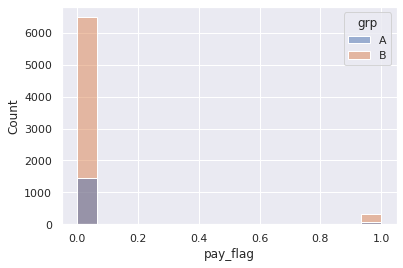

In [28]:
sns.set_theme()
sns.histplot(data=df[df.activity > 0][['grp', 'pay_flag']], hue='grp', x='pay_flag')

In [29]:
stats.shapiro(df.query("activity > 0 and grp == 'A'").pay_flag)

ShapiroResult(statistic=0.22591686248779297, pvalue=0.0)

In [30]:
stats.shapiro(df.query("activity > 0 and grp == 'B'").pay_flag)

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.2125367522239685, pvalue=0.0)

Распределение CR в группах не является нормальным.

**ARPU**

— это отношение дохода к количеству пользователей, посетивших платформу в дни проведения эксперимента.

In [31]:
ARPU = df[df.activity > 0].groupby('grp', as_index=False).agg(ARPU=('rev', 'mean'))
ARPU

,grp,ARPU
0,A,47.347204
1,B,58.058798


In [32]:
ARPU_A = pd.DataFrame(df.query("activity > 0 and grp == 'A'").rev.describe()) \
    .rename(columns={'rev': 'ARPU_in_A'})

ARPU_B = pd.DataFrame(df.query("activity > 0 and grp == 'B'").rev.describe()) \
    .rename(columns={'rev': 'ARPU_in_B'})

pd.concat([ARPU_A, ARPU_B], axis=1)

,ARPU_in_A,ARPU_in_B
count,1538.000000,6803.000000
mean,47.347204,58.058798
std,290.490632,313.770201
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,3660.000000,4650.000000


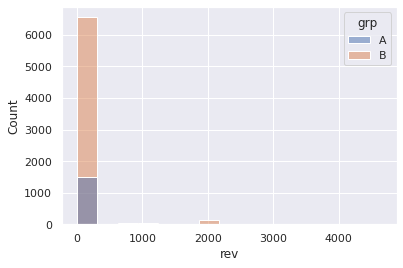

In [33]:
sns.histplot(data=df[df.activity > 0][['grp', 'rev']], hue='grp', x='rev')

In [34]:
stats.shapiro(df.query("activity > 0 and grp == 'A'").rev)

ShapiroResult(statistic=0.1541670560836792, pvalue=0.0)

In [35]:
stats.shapiro(df.query("activity > 0 and grp == 'B'").rev)

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.18124502897262573, pvalue=0.0)

Распределение ARPU в группах не является нормальным.

**ARPPU**

— это отношение дохода к числу пользователей, посетивших платформу и совершивших оплату в дни проведения эксперимента.

In [36]:
ARPPU = df[df.rev > 0].groupby('grp', as_index=False).agg(ARPPU=('rev', 'mean'))
ARPPU

,grp,ARPPU
0,A,933.589744
1,B,1257.878992


In [37]:
ARPPU_A = pd.DataFrame(df.query("rev > 0 and grp == 'A'").rev.describe()) \
    .rename(columns={'rev': 'ARPPU_in_A'})

ARPPU_B = pd.DataFrame(df.query("rev > 0 and grp == 'B'").rev.describe()) \
    .rename(columns={'rev': 'ARPPU_in_B'})

pd.concat([ARPPU_A, ARPPU_B], axis=1)

,ARPPU_in_A,ARPPU_in_B
count,78.000000,314.000000
mean,933.589744,1257.878992
std,919.932711,790.864254
min,199.000000,199.000000
25%,290.000000,511.750000
50%,585.000000,1140.000000
75%,1114.750000,1900.000000
max,3660.000000,4650.000000


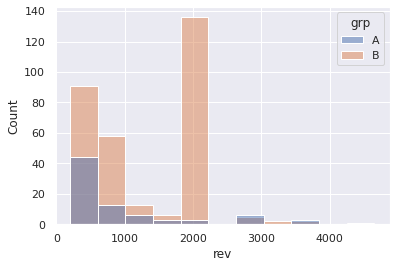

In [38]:
sns.histplot(data=df[df.rev > 0][['grp', 'rev']], hue='grp', x='rev')

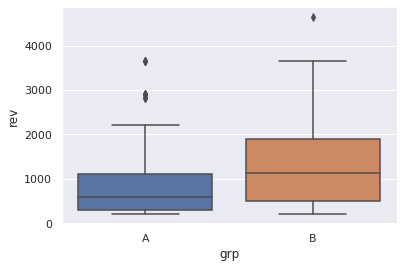

In [39]:
sns.boxplot(data=df[df.rev > 0][['grp', 'rev']], x='grp', y='rev')

In [40]:
stats.shapiro(df.query("rev > 0 and grp == 'A'").rev)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

In [41]:
stats.shapiro(df.query("rev > 0 and grp == 'B'").rev)

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

Распределение ARPPU в группах не является нормальным.

### 2. Имеются ли различия в метриках?

In [42]:
metrics = CR.merge(ARPU).merge(ARPPU)
metrics

,grp,CR,"CR, %",ARPU,ARPPU
0,A,0.050715,5.071521,47.347204,933.589744
1,B,0.046156,4.615611,58.058798,1257.878992


Добавим в конец таблицы 2 строки с разницей значений в группах

In [43]:
x = ['difference']
perc = ['difference_in_%']
for i in metrics[['CR', 'CR, %', 'ARPU', 'ARPPU']]:
    x.append(metrics[i][1] - metrics[i][0])
    perc.append(100 * (metrics[i][1] - metrics[i][0]) / metrics[i][0])
metrics.loc[len(metrics.index)] = x
metrics.loc[len(metrics.index)] = perc
metrics

,grp,CR,"CR, %",ARPU,ARPPU
0,A,0.050715,5.071521,47.347204,933.589744
1,B,0.046156,4.615611,58.058798,1257.878992
2,difference,-0.004559,-0.455911,10.711594,324.289248
3,difference_in_%,-8.989624,-8.989624,22.623498,34.735734


Для дальнейшей работы последние две строки с разницей в метриках нам не пригодятся, уберем их

In [44]:
metrics = metrics.head(2)

- Конверсия **CR** упала на **~9%**
- Средний доход с привлеченного пользователя **ARPU** увеличился на **~23%**
- Средний доход на платящего пользователя **ARPPU** увеличился на **~35%**

### 3. Являются ли эти различия статистически значимыми?

Для ответа на этот вопрос проведем A/B тестирование методом bootstrap (так как размеры групп сильно различны, а распределения в группах не являются нормальными).

In [45]:
plt.style.use('ggplot')

# объявим функцию бутстрап

def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it = 10000,  # количество бутстрэп-подвыборок
    statistic = np.mean,  # интересующая нас статистика
    bootstrap_conf_level = 0.95  # уровень значимости
):
    boot_data = []
    boot_len = max(len(data_column_1), len(data_column_2))
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2=stats.norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

**ГИПОТЕЗЫ**
- H0: метрика в группах статистически значимо не изменилась (p > 0,05)
- H1: метрика в группах различна (p < 0,05)

**CR**

  0%|          | 0/10000 [00:00<?, ?it/s]

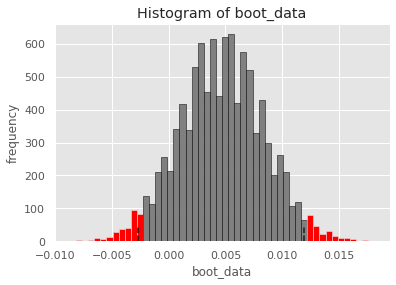

In [46]:
booted_CR = get_bootstrap(df.query("activity > 0 and grp == 'A'").pay_flag, 
                          df.query("activity > 0 and grp == 'B'").pay_flag)

In [47]:
booted_CR["p_value"]

0.2123384833126012

In [48]:
booted_CR["quants"]  # ДИ

,0
0.025,-0.002646
0.975,0.011907


Так как p_value > 0.05, мы не можем отвергнуть нулевую гипотезу о том, что **статистически значимых различий конверсии CR между двумя группами нет.**

**ARPU**

  0%|          | 0/10000 [00:00<?, ?it/s]

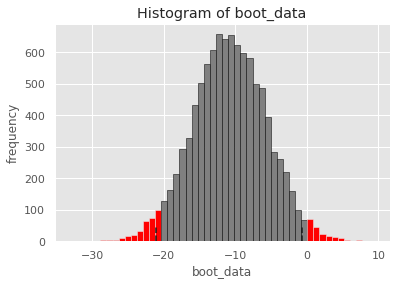

In [49]:
booted_ARPU = get_bootstrap(df.query("activity > 0 and grp == 'A'").rev, 
                            df.query("activity > 0 and grp == 'B'").rev)

In [50]:
booted_ARPU["p_value"]

0.03582858379499591

In [51]:
booted_ARPU["quants"]  # ДИ - не пересекает 0

,0
0.025,-21.058838
0.975,-0.706681


Получили p < 0.05, что означает, что есть основания **отвергнуть нулевую гипотезу** о том, что статистически значимых различий ARPU между двумя группами нет.

**ARPPU**

  0%|          | 0/10000 [00:00<?, ?it/s]

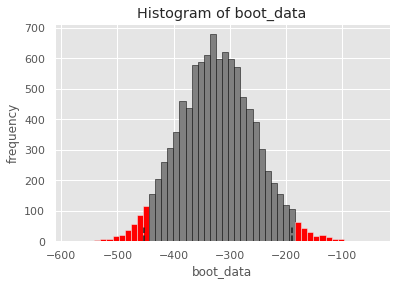

In [52]:
booted_ARPPU = get_bootstrap(df.query("rev > 0 and grp == 'A'").rev, 
                             df.query("rev > 0 and grp == 'B'").rev)

In [53]:
booted_ARPPU["p_value"]

1.9016621771063018e-06

In [54]:
booted_ARPPU["quants"]  # ДИ

,0
0.025,-453.287354
0.975,-188.116332


Получили p < 0.05, что означает, что есть основания **отвергнуть нулевую гипотезу** о том, что статистически значимых различий ARPPU между двумя группами нет.

### 4. Стоит ли запускать новую механику на всех пользователей?

Измерив три метрики, получили ухудшение значений CR и улучшение значений ARPU и ARPPU в целевой группе.

Далее, проведя тестирование методом бутстрап, выяснилось, что ухудшение значений CR не является статистически значимым, а улучшение двух других метрик статистически значимо.

**Таким образом, можно рекомендовать запускать новую механику оплаты на всех пользователей!**

# SQL

## Очень усердные ученики

### Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

### Задача

Дана таблица `default.peas`:

- `st_id` - ID ученика
- `timest` - Время решения карточки
- `correct` - Правильно ли решена горошина?
- `subject` - Дисциплина, в которой находится горошина

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [55]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020' 
                      }

Сначала узнаем, каком именно месяц - "текущий". Для этого посмотрим какие месяцы представлены в таблице:

In [56]:
q = '''
    SELECT DISTINCT toStartOfMonth(timest) as month       
    FROM peas
    '''
df_0 = ph.read_clickhouse(query=q, connection=connection_default) 
df_0

,month
0,2021-10-01


Оказалось, что в таблице один, необходимый нам месяц, поэтому можно не задавать специальное условие для текущего месяца.

Тогда запрос будет выглядеть так:

In [57]:
q = '''
    SELECT COUNT(st_id) AS success_studs
    FROM
        (
        SELECT
            st_id,
            SUM(correct) AS tasks
        FROM peas
        GROUP BY st_id
        HAVING tasks >= 20
        ORDER BY tasks DESC
        )
    '''
df_1 = ph.read_clickhouse(query=q, connection=connection_default) 
df_1

,success_studs
0,136


**Количество очень усердных студентов - 136.**

## Оптимизация воронки

### Условие

Дана таблицы `default.peas` (см. выше), `default.studs`:
- `st_id` - ID ученика
- `test_grp` -  Метка ученика в данном эксперименте

и `default.final_project_check`:

- `st_id` - ID ученика
- `sale_time` - Время покупки
- `money` - Цена, по которой приобрели данный курс
- `subject`

### Задача

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

1. ARPU
2. ARPAU
3. CR в покупку
4. СR активного пользователя в покупку
5. CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

Все данные находятся в табличном виде в ClickHouse.


In [58]:
q = '''
    SELECT 
        b.test_grp AS test_grp,
        ROUND(SUM(c.money)/uniq(b.st_id), 1) AS ARPU,
        ROUND(SUM(CASE WHEN a.tasks > 10 THEN c.money END)/uniq(CASE WHEN a.tasks > 10 THEN b.st_id END), 1) AS ARPAU,
        ROUND(100*uniq(CASE WHEN c.money > 0 THEN b.st_id END)/uniq(b.st_id), 2) AS CR,
        ROUND(100*uniq(CASE WHEN c.money > 0 AND a.tasks > 10 THEN b.st_id END)/
            uniq(CASE WHEN a.tasks > 10 THEN b.st_id END), 2) AS CR_active,
        ROUND(100*uniq(CASE WHEN c.money > 0 AND subject = 'Math' AND a.math_tasks > 2 THEN b.st_id END)/
            uniq(CASE WHEN a.math_tasks >= 2 THEN b.st_id END), 2) AS CR_active_math
    FROM
        (
        SELECT
            st_id,
            SUM(correct) AS tasks,
            SUM(CASE WHEN subject == 'Math' THEN correct END) AS math_tasks
        FROM peas
        GROUP BY st_id
        ) AS a
        FULL JOIN studs AS b ON a.st_id = b.st_id
        FULL JOIN final_project_check AS c ON b.st_id = c.st_id
    GROUP BY test_grp
    '''
df_2 = ph.read_clickhouse(q, connection=connection_default)
df_2

,test_grp,ARPU,ARPAU,CR,CR_active,CR_active_math
0,control,4541.0,10393.7,4.92,11.02,6.12
1,pilot,11508.5,29739.6,10.85,26.04,9.52


# Python
### Задача
1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

### 1. Метрики

**Реализация**

Что должно поступать на вход?

- Исходные данные: таблицы groups, active_studs, checks. Они будут являться аргументами по умолчанию. То есть, во время вызова функции в аргументах вместо каждого можно подставить другой файл с данными, либо вообще не писать их в аргументах - тогда считаются те, что есть в коде до вызова функции.

- Ссылка или файл с дополнительными данными (тоже аргумент по умолчанию): если последним аргументом введена ссылка, то файл будет считываться через API; если последний аргумент во время вызова функции не введен и в корневой папке лежит файл с доп. данными, то он будет считываться оттуда.

ВАЖНО: *файл должен лежать в той же папке, где находится этот код!*

**Функцию можно вызывать без аргументов - в таком случае исходные данные должны быть прописаны выше в коде, а в корневой папке должен лежать файл с доп. данными.**

Что будет на выходе?

- Функция будет возвращать датафрейм с метриками, аналогичиный датафрейму metrics из шага 42, и содержащий в себе: столбцы с названиями групп, CR, CR в %, ARPU, ARPPU.

In [59]:
def update_metrics(groups=groups, active_studs=active_studs, checks=checks, link=""):
    
#     # библиотеки (на всякий случай)
#     import pandas as pd
#     import requests
#     from urllib.parse import urlencode

    # подгружаем groups_add
    if len(link) > 0:
        # через API
        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
        download_url_add = requests.get(base_url + urlencode(dict(public_key=link))).json()['href']
        groups_add = pd.read_csv(download_url_add)
    
    else:
        # через файл
        groups_add = pd.read_csv('group_add.csv')
    
    # флаг для определения активных студентов (на всякий случай - если нет в коде)
    active_studs['activity'] = 1
    
    # объединяем данные
    groups_full = pd.concat([groups, groups_add]).rename(columns={'id': 'student_id'}).reset_index(drop=True)
    df = groups_full.merge(active_studs, on='student_id', how='left').fillna(0) \
        .merge(checks, how='left').fillna(0).reset_index(drop=True)
    
    # удалим студентов с "автоплатежом"
    df_to_del = df.query('activity == 0 and rev > 0')
    df = pd.concat([df, df_to_del]).drop_duplicates(keep=False)
    
    # добавим флаг с фактом оплаты пользователем (1 - производил оплату, 0 - не платил)
    df['pay_flag'] = (df.rev > 0) * 1
    
    # посчитаем метрики
    CR = df[df.activity > 0].groupby('grp', as_index=False).agg(CR=('pay_flag', 'mean'))
    CR['CR, %'] = CR.CR * 100
    ARPU = df[df.activity > 0].groupby('grp', as_index=False).agg(ARPU=('rev', 'mean'))
    ARPPU = df[df.rev > 0].groupby('grp', as_index=False).agg(ARPPU=('rev', 'mean'))
    
    # сформируем общий датафрейм с метриками
    metrics = CR.merge(ARPU).merge(ARPPU)
    
    return metrics

Проверим работу функции. 

Ссылку на доп. файл указывать не будем, так как он лежит в этой же папке. Исходные данные прописаны выше в коде - их тоже не будем указывать. Вызовем функцию без аргументов.

In [60]:
update_metrics()

,grp,CR,"CR, %",ARPU,ARPPU
0,A,0.050715,5.071521,47.347204,933.589744
1,B,0.046156,4.615611,58.058798,1257.878992


### 2. Графики

**Реализация**

Что должно поступать на вход?

- Датафрейм с метриками, аналогичный датафрейму на выходе предыдущей функции.

Что будет на выходе?

- Ничего, так как в теле функции будут строиться 4 барплота, отображающие метрики CR, CR в %, ARPU, ARPPU в группах A и B.

In [61]:
def plots(metric):
    
    # библиотека (на всякий случай)
    import seaborn as sns
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    sns.barplot(data=metric, x='grp', y='CR', ax=axs[0, 0])
    axs[0, 0].set_title('CR')  
    sns.barplot(data=metric, x='grp', y='CR, %', ax=axs[0, 1])
    axs[0, 1].set_title('CR, %')  
    sns.barplot(data=metric, x='grp', y='ARPU', ax=axs[1, 0])
    axs[1, 0].set_title('ARPU')
    sns.barplot(data=metric, x='grp', y='ARPPU', ax=axs[1, 1])
    axs[1, 1].set_title('ARPPU')
    
    return

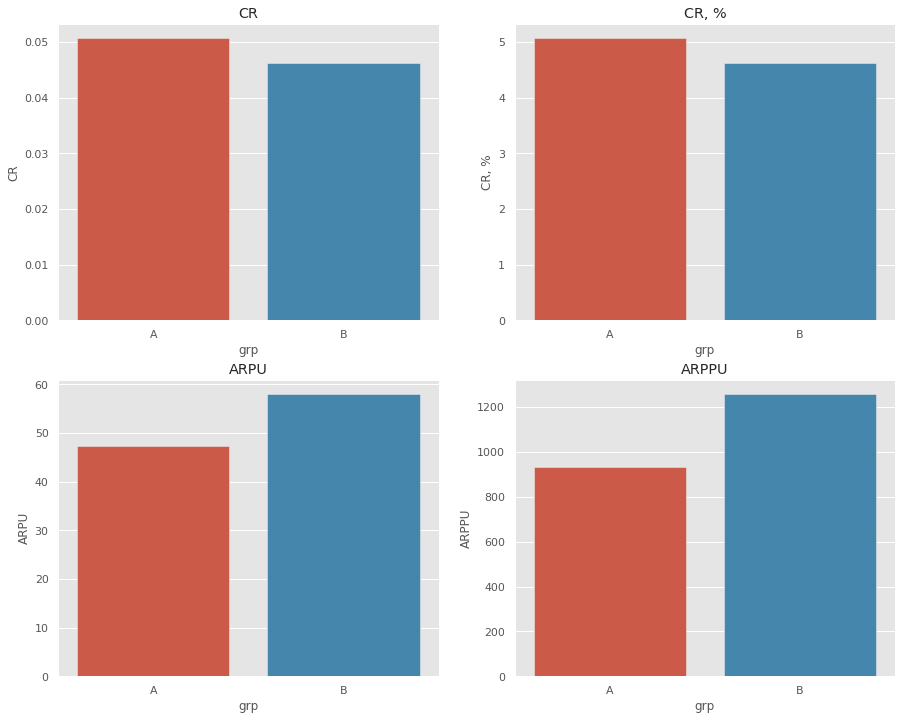

In [62]:
plots(metrics)